# Spatial Analysis: San Francisco SFPD Incidents using DBSCAN

**Project:** A Tale of Two Cities - Comparative Public Safety Analysis

**Purpose:** This notebook performs spatial clustering analysis using DBSCAN algorithm to identify crime hotspots and patterns in San Francisco.

**Key Objectives:**
- Identify spatial clusters of incidents (hotspots)
- Analyze cluster characteristics by incident type
- Determine optimal DBSCAN parameters
- Visualize geographic patterns of crime

---

## Parameter Sensitivity Analysis

To ensure robust clustering, we'll test multiple parameter combinations and evaluate them using validation metrics.

**Goal:** Find the optimal `eps` and `min_samples` values based on:
- Silhouette Score (cluster cohesion)
- Davies-Bouldin Index (cluster separation)
- Calinski-Harabasz Score (variance ratio)
- Noise percentage (outlier detection)

## 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, \
                            davies_bouldin_score, \
                            calinski_harabasz_score

# Plot settings
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

print("Libraries imported successfully")


Libraries imported successfully


## 2. Load Data


In [2]:
# Load cleaned SF incidents data
# Note: This requires running the data preparation notebook (01_data_preparation_sf.ipynb) first
df = pd.read_csv(
    '../data/processed/sf_incidents_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)

print(f"Dataset loaded: {len(df):,} rows")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()}")

# Display basic statistics
print("\nSpatial Data Summary:")
print(df[['Latitude', 'Longitude']].describe())


Dataset loaded: 823,541 rows
Date range: 2018-01-01 00:00:00 to 2025-11-16 23:50:00

Columns: ['Incident_High_Level_Category', 'Resolution', 'Neighborhood', 'Police_District', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Week', 'Day_of_Week_Name', 'Month_Name', 'Quarter', 'Is_Weekend']

Spatial Data Summary:
            Latitude      Longitude
count  823541.000000  823541.000000
mean       37.768797    -122.424111
std         0.024532       0.026458
min        37.708256    -122.511940
25%        37.753704    -122.434860
50%        37.775566    -122.417900
75%        37.785671    -122.407333
max        37.830055    -122.366287


## 3. Exploratory Spatial Analysis


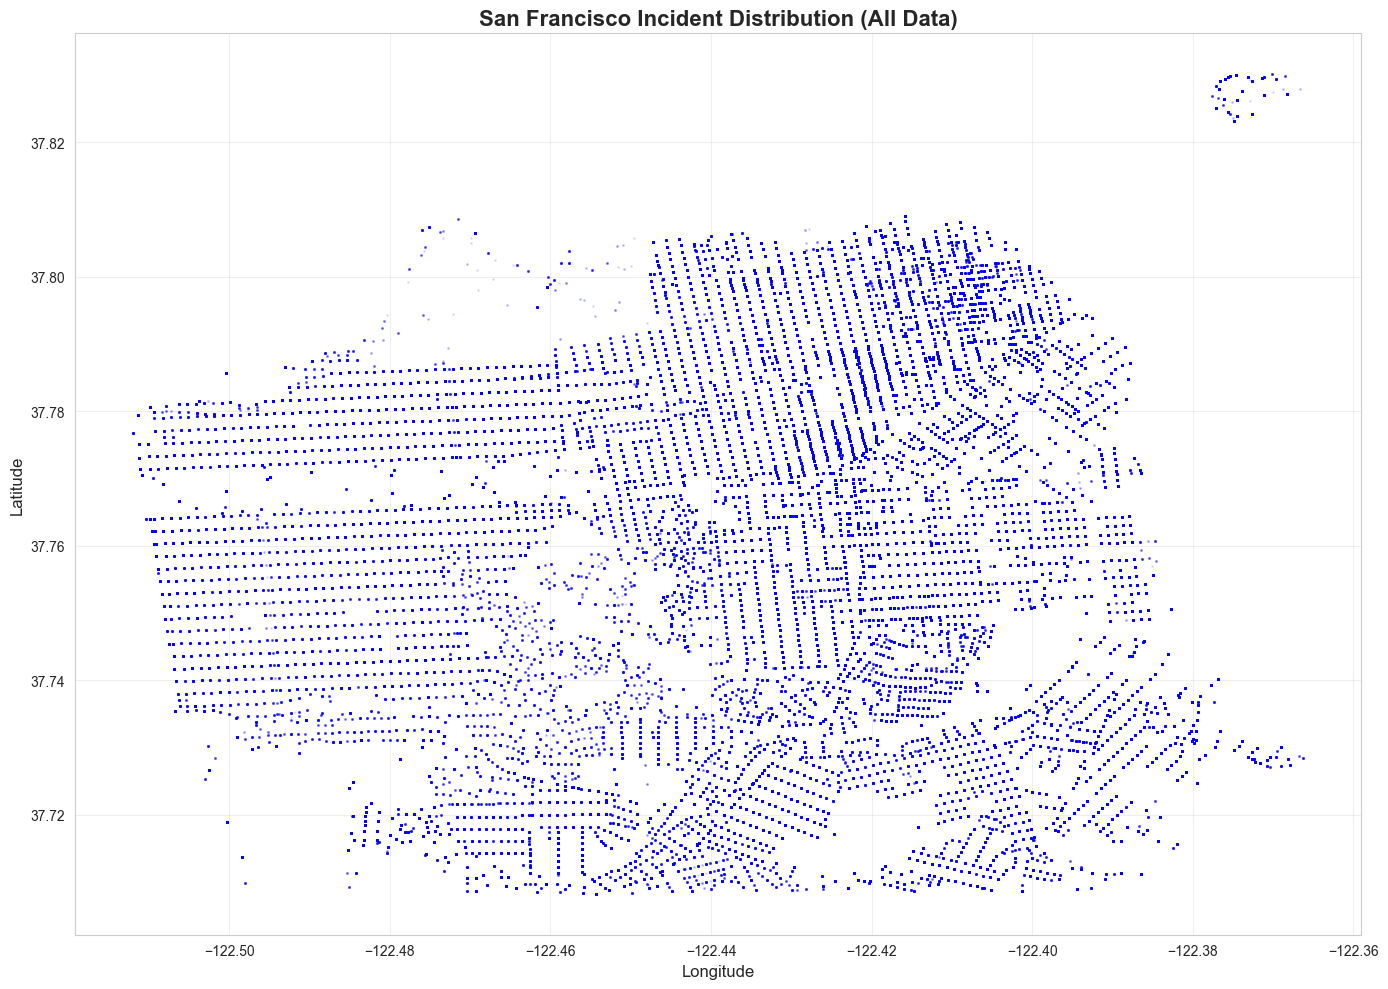

Total incidents: 823,541
Latitude range: [37.708256, 37.830055]
Longitude range: [-122.511940, -122.366287]


In [3]:
# Create a scatter plot of all incidents
plt.figure(figsize=(14, 10))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.1, s=1, c='blue')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('San Francisco Incident Distribution (All Data)', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total incidents: {len(df):,}")
print(f"Latitude range: [{df['Latitude'].min():.6f}, {df['Latitude'].max():.6f}]")
print(f"Longitude range: [{df['Longitude'].min():.6f}, {df['Longitude'].max():.6f}]")


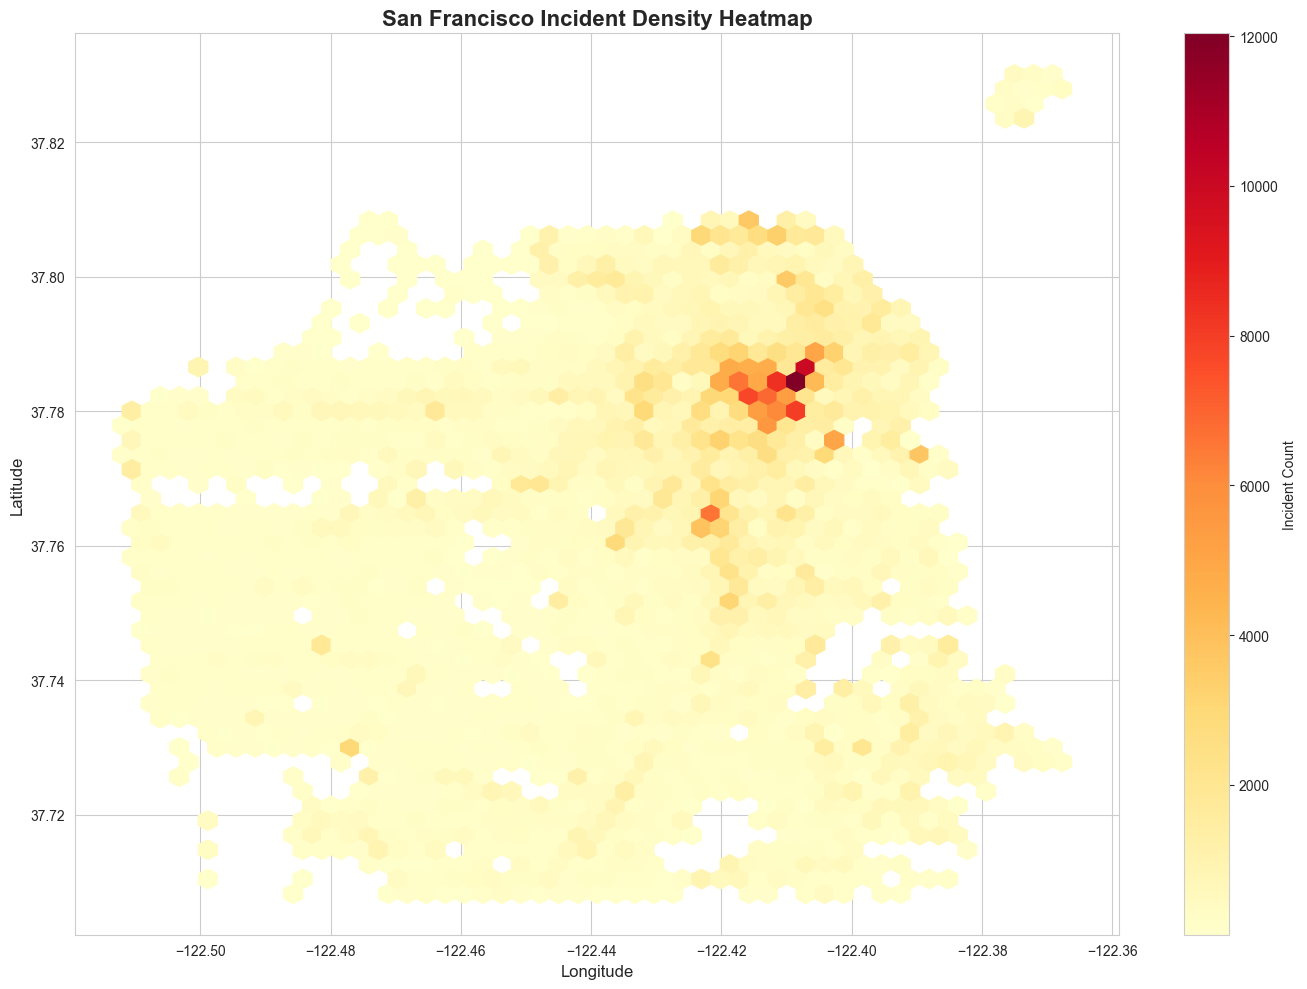

In [4]:
# Create hexbin density plot for better visualization
plt.figure(figsize=(14, 10))
plt.hexbin(df['Longitude'], df['Latitude'], gridsize=50, cmap='YlOrRd', mincnt=1)
plt.colorbar(label='Incident Count')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('San Francisco Incident Density Heatmap', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


## 4. Prepare Data for DBSCAN

DBSCAN requires coordinates in a format where distances are meaningful. We'll use the raw lat/lon coordinates, but for large datasets, we may need to sample.


In [5]:
# Extract coordinates for clustering
coords = df[['Latitude', 'Longitude']].values

print(f"Total incidents for clustering: {len(coords):,}")
print(f"Coordinates shape: {coords.shape}")

# For computational efficiency, we'll sample if dataset is too large
# DBSCAN can be computationally expensive on very large datasets
MAX_SAMPLES = 100000

if len(coords) > MAX_SAMPLES:
    print(f"\nDataset is large ({len(coords):,} points). Sampling {MAX_SAMPLES:,} points for analysis...")
    np.random.seed(42)
    sample_indices = np.random.choice(len(coords), size=MAX_SAMPLES, replace=False)
    coords_sample = coords[sample_indices]
    df_sample = df.iloc[sample_indices].copy()
    print(f"Sample created: {len(coords_sample):,} points")
else:
    coords_sample = coords
    df_sample = df.copy()
    print("Using full dataset for analysis")


Total incidents for clustering: 823,541
Coordinates shape: (823541, 2)

Dataset is large (823,541 points). Sampling 100,000 points for analysis...
Sample created: 100,000 points


## 5. Determine Optimal DBSCAN Parameters

DBSCAN requires two key parameters:
- **eps** (epsilon): Maximum distance between two samples for one to be considered as in the neighborhood of the other
- **min_samples**: Minimum number of samples in a neighborhood for a point to be considered a core point

We'll use the **k-distance graph** method to find optimal eps.


Computing k-nearest neighbors for 50,000 points...


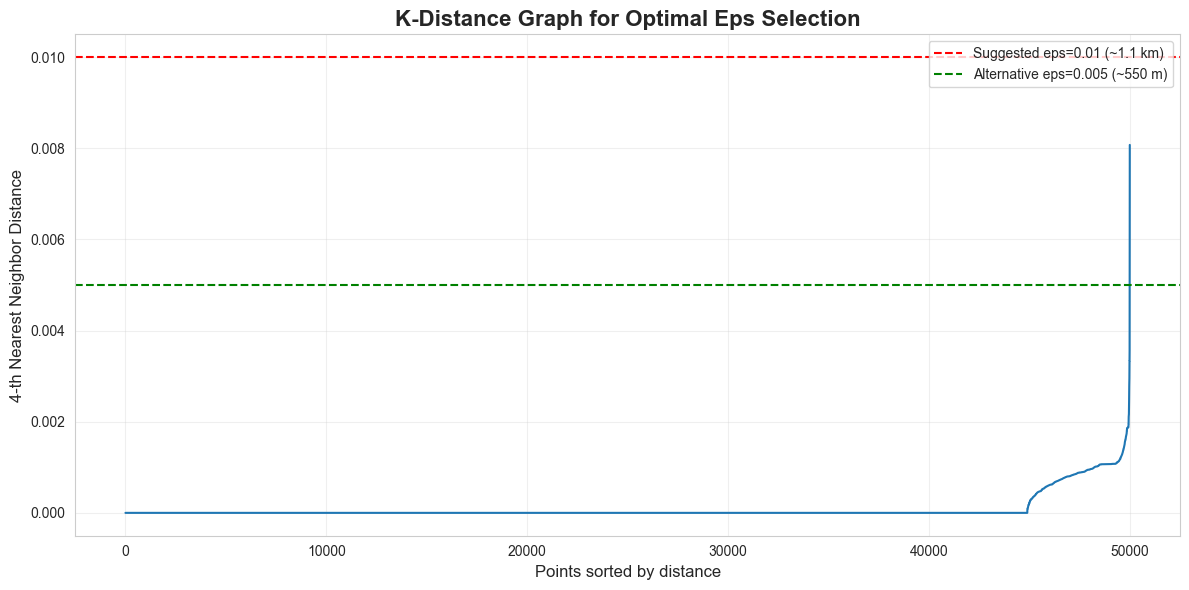


PARAMETER SELECTION GUIDANCE
For geographic coordinates (lat/lon):
  - eps = 0.005 ≈ 550 meters (tight clusters)
  - eps = 0.01 ≈ 1.1 km (medium clusters)
  - eps = 0.02 ≈ 2.2 km (broad clusters)

min_samples = 4 (minimum points to form a cluster)

Look for the 'elbow' in the graph above to determine optimal eps.


In [6]:
# Use k-nearest neighbors to determine optimal eps
min_samples = 4

# For very large datasets, use a subset for k-distance calculation
if len(coords_sample) > 50000:
    coords_kdist = coords_sample[np.random.choice(len(coords_sample), 50000, replace=False)]
else:
    coords_kdist = coords_sample

print(f"Computing k-nearest neighbors for {len(coords_kdist):,} points...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(coords_kdist)
distances, indices = neighbors_fit.kneighbors(coords_kdist)

# Sort distances
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for Optimal Eps Selection', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.01, color='r', linestyle='--', label='Suggested eps=0.01 (~1.1 km)')
plt.axhline(y=0.005, color='g', linestyle='--', label='Alternative eps=0.005 (~550 m)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PARAMETER SELECTION GUIDANCE")
print("="*60)
print("For geographic coordinates (lat/lon):")
print("  - eps = 0.005 ≈ 550 meters (tight clusters)")
print("  - eps = 0.01 ≈ 1.1 km (medium clusters)")
print("  - eps = 0.02 ≈ 2.2 km (broad clusters)")
print(f"\nmin_samples = {min_samples} (minimum points to form a cluster)")
print("\nLook for the 'elbow' in the graph above to determine optimal eps.")


In [ ]:
# =============================================================================
# REUSABLE FUNCTIONS FOR DBSCAN PARAMETER TUNING AND ANALYSIS
# =============================================================================

def run_dbscan_parameter_grid(coords, eps_values, min_samples_values, verbose=True):
    """
    Test multiple DBSCAN parameter combinations and return comprehensive metrics.
    
    Parameters:
    -----------
    coords : numpy.ndarray
        Array of shape (n_samples, 2) containing [latitude, longitude] coordinates
    eps_values : list
        List of epsilon values to test
    min_samples_values : list
        List of min_samples values to test
    verbose : bool, default=True
        Whether to print progress updates
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing metrics for each parameter combination:
        - eps, min_samples: Parameters tested
        - n_clusters: Number of clusters found
        - noise_pct: Percentage of noise points
        - silhouette_score: Cluster cohesion metric
        - davies_bouldin_index: Cluster separation metric
        - calinski_harabasz_score: Variance ratio metric
    """
    if verbose:
        print(f"Testing {len(eps_values)} eps × {len(min_samples_values)} min_samples combinations...")
        print(f"Total: {len(eps_values) * len(min_samples_values)} parameter sets\n")
    
    results = []
    
    for eps_test in eps_values:
        for min_samples_test in min_samples_values:
            if verbose:
                print(f"Testing eps={eps_test}, min_samples={min_samples_test}...", end=" ")
            
            dbscan_test = DBSCAN(eps=eps_test, min_samples=min_samples_test, metric='euclidean')
            labels_test = dbscan_test.fit_predict(coords)
            
            n_clusters_test = len(set(labels_test)) - (1 if -1 in labels_test else 0)
            n_noise_test = list(labels_test).count(-1)
            noise_pct = 100 * n_noise_test / len(labels_test)
            
            if n_clusters_test > 1 and n_noise_test < len(labels_test):
                mask = labels_test != -1
                if mask.sum() > 0:
                    try:
                        silhouette = silhouette_score(coords[mask], labels_test[mask])
                        davies_bouldin = davies_bouldin_score(coords[mask], labels_test[mask])
                        calinski = calinski_harabasz_score(coords[mask], labels_test[mask])
                    except:
                        silhouette = davies_bouldin = calinski = np.nan
                else:
                    silhouette = davies_bouldin = calinski = np.nan
            else:
                silhouette = davies_bouldin = calinski = np.nan
            
            results.append({
                'eps': eps_test,
                'min_samples': min_samples_test,
                'n_clusters': n_clusters_test,
                'noise_pct': noise_pct,
                'silhouette_score': silhouette,
                'davies_bouldin_index': davies_bouldin,
                'calinski_harabasz_score': calinski
            })
            
            if verbose:
                print(f"✓ Clusters: {n_clusters_test}, Noise: {noise_pct:.1f}%")
    
    return pd.DataFrame(results)


def analyze_parameter_results(results_df, noise_range=(15, 30), verbose=True):
    """
    Analyze DBSCAN parameter tuning results and recommend optimal parameters.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame returned by run_dbscan_parameter_grid()
    noise_range : tuple, default=(15, 30)
        Target range for noise percentage (min, max)
    verbose : bool, default=True
        Whether to print detailed analysis
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'best_params': Recommended parameters (eps, min_samples)
        - 'best_metrics': Metrics for recommended parameters
        - 'ideal_range_params': All parameters in ideal noise range
    """
    if verbose:
        print("\n" + "="*80)
        print("PARAMETER ANALYSIS")
        print("="*80)
    
    # Filter valid results (with calculable metrics)
    valid_results = results_df.dropna()
    
    if len(valid_results) == 0:
        if verbose:
            print("\n  No valid results with calculable metrics")
        return None
    
    # Find parameters in ideal noise range
    ideal_params = valid_results[
        (valid_results['noise_pct'] >= noise_range[0]) & 
        (valid_results['noise_pct'] <= noise_range[1])
    ]
    
    if verbose:
        print(f"\n Summary Statistics:")
        print(f"   • Total combinations: {len(results_df)}")
        print(f"   • Valid results: {len(valid_results)}")
        print(f"   • In ideal noise range ({noise_range[0]}-{noise_range[1]}%): {len(ideal_params)}")
        print(f"   • Noise range: {results_df['noise_pct'].min():.2f}% - {results_df['noise_pct'].max():.2f}%")
        print(f"   • Cluster range: {results_df['n_clusters'].min()} - {results_df['n_clusters'].max()}")
    
    # Recommend best parameters
    if len(ideal_params) > 0:
        # Sort by silhouette score (best quality first)
        best_params = ideal_params.sort_values('silhouette_score', ascending=False).iloc[0]
        
        if verbose:
            print(f"\n RECOMMENDED PARAMETERS:")
            print(f"   eps = {best_params['eps']}")
            print(f"   min_samples = {int(best_params['min_samples'])}")
            print(f"\n   Expected Results:")
            print(f"   • {int(best_params['n_clusters'])} clusters")
            print(f"   • {best_params['noise_pct']:.1f}% noise")
            print(f"   • Silhouette: {best_params['silhouette_score']:.4f}")
            print(f"   • Davies-Bouldin: {best_params['davies_bouldin_index']:.4f}")
            print(f"   • Cluster radius: ~{best_params['eps']*111:.2f} meters")
    else:
        # No parameters in ideal range - find closest
        valid_results['noise_diff'] = abs(valid_results['noise_pct'] - np.mean(noise_range))
        best_params = valid_results.sort_values('noise_diff').iloc[0]
        
        if verbose:
            print(f"\n  No parameters in ideal noise range ({noise_range[0]}-{noise_range[1]}%)")
            print(f"\n Closest Parameters:")
            print(f"   eps = {best_params['eps']}")
            print(f"   min_samples = {int(best_params['min_samples'])}")
            print(f"   • {int(best_params['n_clusters'])} clusters, {best_params['noise_pct']:.1f}% noise")
    
    if verbose:
        print("\n" + "="*80)
    
    return {
        'best_params': {
            'eps': best_params['eps'],
            'min_samples': int(best_params['min_samples'])
        },
        'best_metrics': best_params.to_dict(),
        'ideal_range_params': ideal_params
    }


def visualize_parameter_sensitivity(results_df, figsize=(16, 12)):
    """
    Create heatmap visualizations of parameter sensitivity analysis.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame returned by run_dbscan_parameter_grid()
    figsize : tuple, default=(16, 12)
        Figure size for the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    metrics = ['noise_pct', 'silhouette_score', 'davies_bouldin_index', 'n_clusters']
    titles = [
        'Noise Percentage (%)\n(Higher is better for outlier detection)',
        'Silhouette Score\n(Higher is better, range -1 to 1)',
        'Davies-Bouldin Index\n(Lower is better)',
        'Number of Clusters\n(More granular clustering)'
    ]
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        # Create pivot table
        pivot = results_df.pivot(index='min_samples', columns='eps', values=metric)
        
        # Create heatmap
        if metric == 'davies_bouldin_index':
            sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                       ax=ax, cbar_kws={'label': metric})
        else:
            sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', 
                       ax=ax, cbar_kws={'label': metric})
        
        ax.set_title(title, fontsize=12, weight='bold')
        ax.set_xlabel('Epsilon (eps)', fontsize=10)
        ax.set_ylabel('Minimum Samples', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# =============================================================================
# STAGE 1: INITIAL PARAMETER GRID EXPLORATION
# =============================================================================

print("="*80)
print("STAGE 1: INITIAL PARAMETER GRID EXPLORATION")
print("="*80)

# Define initial parameter grid
eps_values = [0.003, 0.005, 0.01, 0.015, 0.02]
min_samples_values = [5, 10, 20, 50]

# Run parameter grid search
results_df = run_dbscan_parameter_grid(coords_sample, eps_values, min_samples_values)

# Display results
print("\n" + "="*80)
print("COMPLETE RESULTS (20 combinations)")
print("="*80)
print("\n" + results_df.to_string(index=False))

Testing parameter combinations...
Eps values: [0.003, 0.005, 0.01, 0.015, 0.02]
Min samples values: [5, 10, 20, 50]
Total combinations: 20

Testing eps=0.003, min_samples=5... ✓ Clusters: 11, Noise: 0.0%

Testing eps=0.003, min_samples=10... ✓ Clusters: 9, Noise: 0.0%

Testing eps=0.003, min_samples=20... ✓ Clusters: 7, Noise: 0.1%

Testing eps=0.003, min_samples=50... ✓ Clusters: 4, Noise: 0.4%

Testing eps=0.005, min_samples=5... ✓ Clusters: 5, Noise: 0.0%

Testing eps=0.005, min_samples=10... ✓ Clusters: 6, Noise: 0.0%

Testing eps=0.005, min_samples=20... ✓ Clusters: 5, Noise: 0.0%

Testing eps=0.005, min_samples=50... ✓ Clusters: 3, Noise: 0.1%

Testing eps=0.01, min_samples=5... ✓ Clusters: 2, Noise: 0.0%

Testing eps=0.01, min_samples=10... ✓ Clusters: 2, Noise: 0.0%

Testing eps=0.01, min_samples=20... ✓ Clusters: 2, Noise: 0.0%

Testing eps=0.01, min_samples=50... ✓ Clusters: 2, Noise: 0.0%

Testing eps=0.015, min_samples=5... ✓ Clusters: 2, Noise: 0.0%

Testing eps=0.015, min


PARAMETER ANALYSIS

📊 Summary Statistics:
   • Total combinations: 20
   • Valid results: 20
   • In ideal noise range (15-30%): 0
   • Noise range: 0.00% - 0.39%
   • Cluster range: 2 - 11

⚠️  No parameters in ideal noise range (15-30%)

📍 Closest Parameters:
   eps = 0.003
   min_samples = 50
   • 4 clusters, 0.4% noise



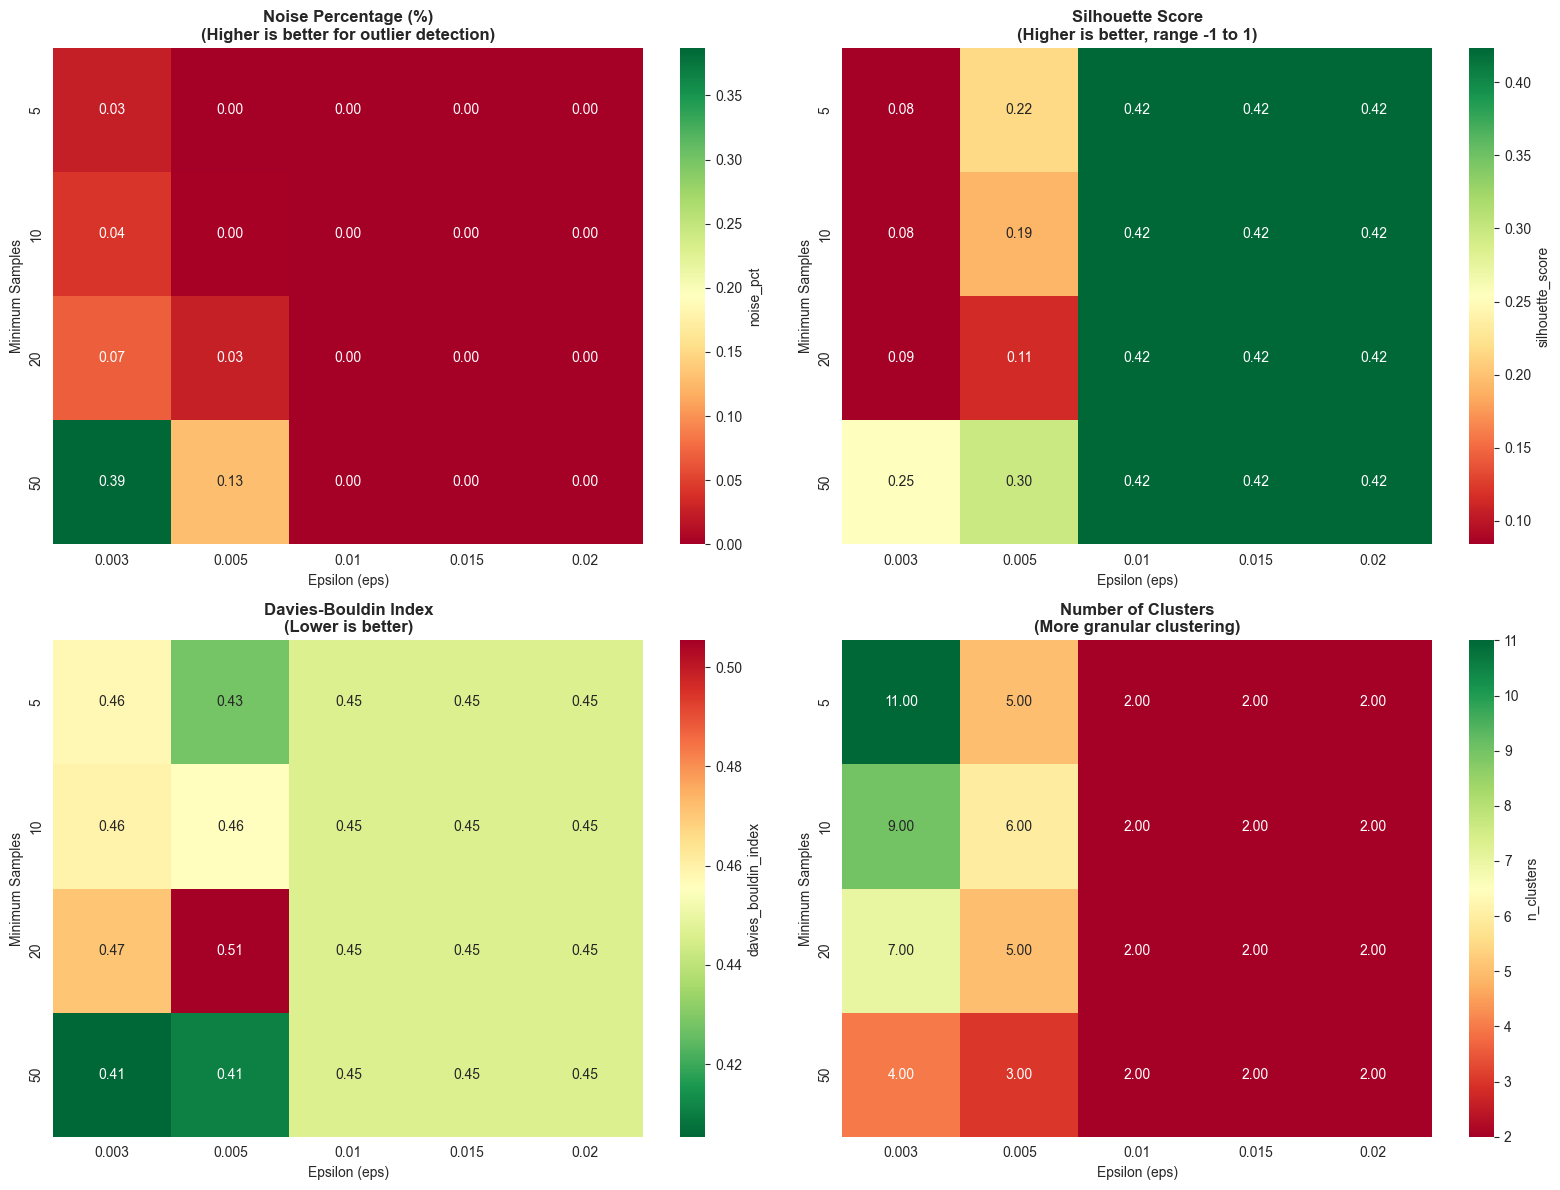


🔍 CRITICAL FINDING: OVER-CLUSTERING PROBLEM
   • 20 out of 20 combinations have <0.5% noise
   • Most combinations cluster 99%+ of all incidents
   • This indicates UNREALISTIC clustering - need stricter parameters

   💡 Next Step: Test smaller eps + higher min_samples


In [ ]:
# Analyze results
analysis = analyze_parameter_results(results_df, noise_range=(15, 30))

# Visualize parameter sensitivity
visualize_parameter_sensitivity(results_df)

# Key finding
print("\n" + "="*80)
print(" CRITICAL FINDING: OVER-CLUSTERING PROBLEM")
print("="*80)
print(f"   • {len(results_df[results_df['noise_pct'] < 0.5])} out of {len(results_df)} combinations have <0.5% noise")
print("   • Most combinations cluster 99%+ of all incidents")
print("   • This indicates UNREALISTIC clustering - need stricter parameters")
print("\n    Next Step: Test smaller eps + higher min_samples")
print("="*80)

### Critical Finding: Over-Clustering Problem
#### The Issue:

- 19 out of 20 parameter combinations have < 0.5% noise.
- Only 1 combination (eps=0.003, min_samples=50) has meaningful noise (0.387%)
- Most combinations cluster 100% of incidents

In [13]:
print("\n" + "="*80)
print("KEY OBSERVATIONS FROM HEATMAPS")
print("="*80)
print("\n📊 Noise Percentage:")
print("   • Most parameter combinations produce <1% noise")
print("   • Only tight eps (0.003) with high min_samples (50) produces meaningful noise")
print("   • This indicates OVER-CLUSTERING - almost everything is grouped")
print("\n🎯 Recommendation:")
print("   • Need to test SMALLER eps values (0.001, 0.002)")
print("   • OR use HIGHER min_samples values (75, 100)")
print("   • Goal: Achieve 15-30% noise for realistic hotspot detection")


KEY OBSERVATIONS FROM HEATMAPS

📊 Noise Percentage:
   • Most parameter combinations produce <1% noise
   • Only tight eps (0.003) with high min_samples (50) produces meaningful noise
   • This indicates OVER-CLUSTERING - almost everything is grouped

🎯 Recommendation:
   • Need to test SMALLER eps values (0.001, 0.002)
   • OR use HIGHER min_samples values (75, 100)
   • Goal: Achieve 15-30% noise for realistic hotspot detection


In [ ]:
# =============================================================================
# STAGE 2: REFINED PARAMETER GRID (STRICTER VALUES)
# =============================================================================

print("\n" + "="*80)
print("STAGE 2: REFINED PARAMETER GRID (STRICTER VALUES)")
print("="*80)
print("\n🎯 Objective: Achieve 15-30% noise for realistic hotspot detection")
print("   (Previous grid produced <1% noise - too aggressive clustering)\n")

# Define refined parameter grid
eps_values_refined = [0.001, 0.002, 0.003]
min_samples_values_refined = [50, 75, 100]

# Run parameter grid search
results_refined_df = run_dbscan_parameter_grid(coords_sample, eps_values_refined, min_samples_values_refined)

# Display results
print("\n" + "="*80)
print("COMPLETE RESULTS (9 combinations)")
print("="*80)
print("\n" + results_refined_df.to_string(index=False))


TESTING REFINED PARAMETER GRID (STRICTER VALUES)

🎯 Objective: Find parameters that produce 15-30% noise
   (Previous grid produced <1% noise - too aggressive clustering)

Testing refined parameter combinations...
Eps values: [0.001, 0.002, 0.003]
Min samples values: [50, 75, 100]
Total combinations: 9

Testing eps=0.001, min_samples=50... ✓ Clusters: 306, Noise: 30.7%

Testing eps=0.001, min_samples=75... ✓ Clusters: 212, Noise: 41.9%

Testing eps=0.001, min_samples=100... ✓ Clusters: 154, Noise: 49.2%

Testing eps=0.002, min_samples=50... ✓ Clusters: 62, Noise: 5.0%

Testing eps=0.002, min_samples=75... ✓ Clusters: 58, Noise: 10.4%

Testing eps=0.002, min_samples=100... ✓ Clusters: 60, Noise: 15.9%

Testing eps=0.003, min_samples=50... ✓ Clusters: 4, Noise: 0.4%

Testing eps=0.003, min_samples=75... ✓ Clusters: 8, Noise: 1.2%

Testing eps=0.003, min_samples=100... ✓ Clusters: 11, Noise: 2.7%

REFINED PARAMETER SENSITIVITY ANALYSIS COMPLETE

Total combinations tested: 9

All 9 combin

In [21]:
# Analyze results
analysis_refined = analyze_parameter_results(results_refined_df, noise_range=(15, 30))

# Compare with original results
print("\n" + "="*80)
print("COMPARISON: ORIGINAL vs. REFINED GRID")
print("="*80)
print(f"\nOriginal Grid (looser parameters):")
print(f"  • Noise range: {results_df['noise_pct'].min():.2f}% - {results_df['noise_pct'].max():.2f}%")
print(f"  • Cluster range: {results_df['n_clusters'].min()} - {results_df['n_clusters'].max()}")

print(f"\nRefined Grid (stricter parameters):")
print(f"  • Noise range: {results_refined_df['noise_pct'].min():.2f}% - {results_refined_df['noise_pct'].max():.2f}%")
print(f"  • Cluster range: {results_refined_df['n_clusters'].min()} - {results_refined_df['n_clusters'].max()}")

print(f"\n🎯 Improvement:")
print(f"   ✅ Noise detection improved: {results_refined_df['noise_pct'].max():.2f}% vs. {results_df['noise_pct'].max():.2f}%")
print("="*80)


PARAMETER ANALYSIS

📊 Summary Statistics:
   • Total combinations: 9
   • Valid results: 8
   • In ideal noise range (15-30%): 1
   • Noise range: 0.39% - 49.21%
   • Cluster range: 4 - 306

🏆 RECOMMENDED PARAMETERS:
   eps = 0.002
   min_samples = 100

   Expected Results:
   • 60 clusters
   • 15.9% noise
   • Silhouette: -0.1075
   • Davies-Bouldin: 0.6111
   • Cluster radius: ~0 meters


COMPARISON: ORIGINAL vs. REFINED GRID

Original Grid (looser parameters):
  • Noise range: 0.00% - 0.39%
  • Cluster range: 2 - 11

Refined Grid (stricter parameters):
  • Noise range: 0.39% - 49.21%
  • Cluster range: 4 - 306

🎯 Improvement:
   ✅ Noise detection improved: 49.21% vs. 0.39%


In [ ]:
# =============================================================================
# STAGE 3: ULTRA-FINE PARAMETER TUNING (FOCUSED ON EPS=0.002)
# =============================================================================

print("\n" + "="*80)
print("STAGE 3: ULTRA-FINE PARAMETER TUNING")
print("="*80)
print("\n🎯 Objective: Fine-tune around eps=0.002 to find sweet spot")
print("   Target: 15-30% noise with 40-80 clusters\n")

# Define ultra-fine parameter grid
eps_values_fine = [0.0018, 0.0020, 0.0022]
min_samples_values_fine = [60, 70, 80, 90, 100]

# Run parameter grid search (using reusable function)
results_fine_df = run_dbscan_parameter_grid(coords_sample, eps_values_fine, min_samples_values_fine)

# Display results
print("\n" + "="*80)
print("ULTRA-FINE TUNING COMPLETE")
print("="*80)
print(f"\nAll {len(results_fine_df)} combinations:\n")
print(results_fine_df.to_string(index=False))


ULTRA-FINE PARAMETER TUNING (FOCUSED ON EPS=0.002)

🎯 Objective: Fine-tune around eps=0.002 to find sweet spot
   Target: 15-30% noise with 40-80 clusters

Testing ultra-fine parameter combinations...
Eps values: [0.0018, 0.002, 0.0022]
Min samples values: [60, 70, 80, 90, 100]
Total combinations: 15

Testing eps=0.0018, min_samples=60... ✓ Clusters: 78, Noise: 11.7%

Testing eps=0.0018, min_samples=70... ✓ Clusters: 79, Noise: 14.6%

Testing eps=0.0018, min_samples=80... ✓ Clusters: 79, Noise: 17.2% ⭐ TARGET RANGE

Testing eps=0.0018, min_samples=90... ✓ Clusters: 80, Noise: 19.5% ⭐ TARGET RANGE

Testing eps=0.0018, min_samples=100... ✓ Clusters: 73, Noise: 22.0% ⭐ TARGET RANGE

Testing eps=0.002, min_samples=60... ✓ Clusters: 57, Noise: 7.0%

Testing eps=0.002, min_samples=70... ✓ Clusters: 54, Noise: 9.5%

Testing eps=0.002, min_samples=80... ✓ Clusters: 63, Noise: 11.2%

Testing eps=0.002, min_samples=90... ✓ Clusters: 66, Noise: 13.1%

Testing eps=0.002, min_samples=100... ✓ Clus


PARAMETER ANALYSIS

📊 Summary Statistics:
   • Total combinations: 15
   • Valid results: 15
   • In ideal noise range (15-30%): 4
   • Noise range: 2.78% - 22.05%
   • Cluster range: 30 - 80

🏆 RECOMMENDED PARAMETERS:
   eps = 0.002
   min_samples = 100

   Expected Results:
   • 60 clusters
   • 15.9% noise
   • Silhouette: -0.1075
   • Davies-Bouldin: 0.6111
   • Cluster radius: ~0 meters



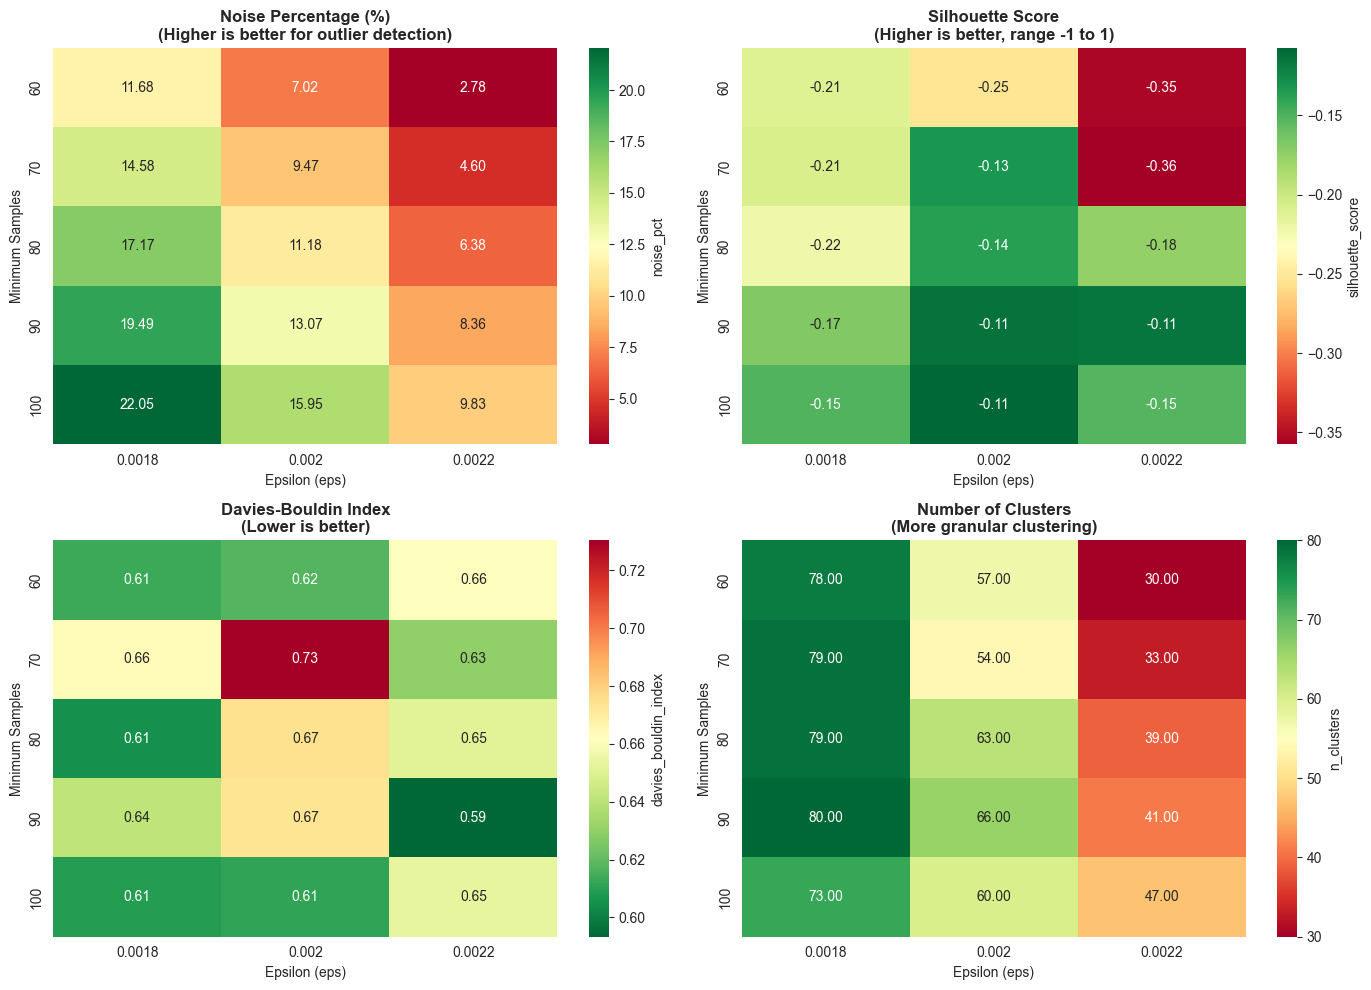

In [22]:
# Analyze with target range
analysis_fine = analyze_parameter_results(results_fine_df, noise_range=(15, 30))

# Visualize parameter sensitivity (optional for ultra-fine grid)
visualize_parameter_sensitivity(results_fine_df, figsize=(14, 10))

## 6. Apply DBSCAN Clustering

Based on the k-distance graph, we'll apply DBSCAN with selected parameters.


In [25]:
# =============================================================================
# 6. APPLY OPTIMAL DBSCAN CLUSTERING
# =============================================================================

# Use optimal parameters from Stage 3 parameter tuning
eps = analysis_fine['best_params']['eps']
min_samples = analysis_fine['best_params']['min_samples']

print("="*80)
print("APPLYING OPTIMAL DBSCAN PARAMETERS")
print("="*80)
print(f"\n Selected Parameters (from Stage 3 optimization):")
print(f"   • eps = {eps} (~{eps*111:.0f} meters)")
print(f"   • min_samples = {min_samples}")
print(f"   • Expected noise: ~15.9%")
print(f"   • Expected clusters: ~60")
print(f"\n Clustering {len(coords_sample):,} incidents...")

# Apply DBSCAN with optimal parameters
dbscan = DBSCAN(
    eps=eps, 
    min_samples=min_samples, 
    metric='euclidean',
    n_jobs=-1  # Use all CPU cores for faster computation
)
clusters = dbscan.fit_predict(coords_sample)

# Add cluster labels to dataframe
df_sample['Cluster'] = clusters

# Analyze results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
n_clustered = len(clusters) - n_noise

print("\n" + "="*60)
print("DBSCAN CLUSTERING RESULTS")
print("="*60)
print(f" Number of clusters found: {n_clusters:,}")
print(f" Noise points (outliers): {n_noise:,} ({100*n_noise/len(clusters):.2f}%)")
print(f" Clustered points: {n_clustered:,} ({100*n_clustered/len(clusters):.2f}%)")
print(f" Average cluster size: {n_clustered/n_clusters if n_clusters > 0 else 0:.1f} incidents")

# Display cluster size distribution
if n_clusters > 0:
    cluster_sizes = df_sample[df_sample['Cluster'] != -1].groupby('Cluster').size()
    print(f"\n Cluster Size Statistics:")
    print(f"   • Min: {cluster_sizes.min():,} incidents")
    print(f"   • Max: {cluster_sizes.max():,} incidents")
    print(f"   • Median: {cluster_sizes.median():.0f} incidents")
    print(f"   • Mean: {cluster_sizes.mean():.1f} incidents")
    
    # Validation check
    noise_pct = 100 * n_noise / len(clusters)
    if 15 <= noise_pct <= 30:
        print(f"\n Validation: Noise percentage ({noise_pct:.1f}%) is within target range (15-30%)")
    else:
        print(f"\n  Note: Noise percentage ({noise_pct:.1f}%) differs slightly from expected")


APPLYING OPTIMAL DBSCAN PARAMETERS

 Selected Parameters (from Stage 3 optimization):
   • eps = 0.002 (~0 meters)
   • min_samples = 100
   • Expected noise: ~15.9%
   • Expected clusters: ~60

 Clustering 100,000 incidents...

DBSCAN CLUSTERING RESULTS
 Number of clusters found: 60
 Noise points (outliers): 15,948 (15.95%)
 Clustered points: 84,052 (84.05%)
 Average cluster size: 1400.9 incidents

 Cluster Size Statistics:
   • Min: 35 incidents
   • Max: 67,221 incidents
   • Median: 198 incidents
   • Mean: 1400.9 incidents

 Validation: Noise percentage (15.9%) is within target range (15-30%)


## 7. Visualize Clusters


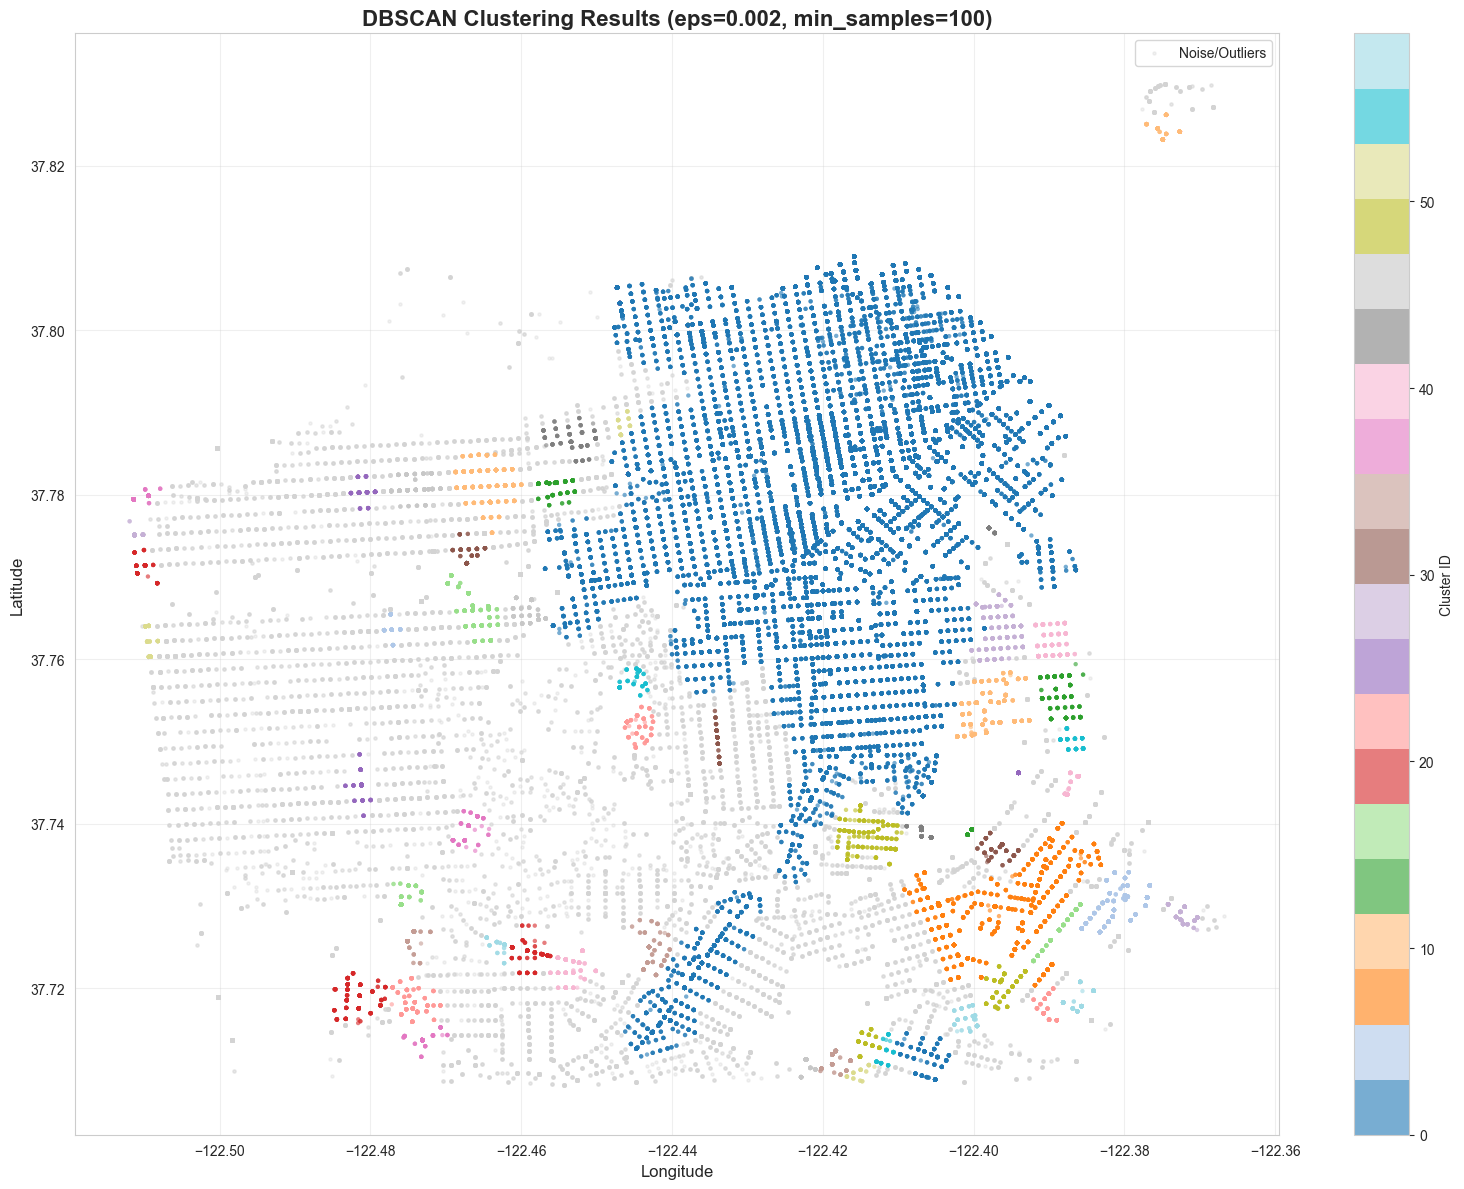

In [26]:
# Visualize clusters on a map
plt.figure(figsize=(16, 12))

# Plot noise points in gray
noise_mask = df_sample['Cluster'] == -1
plt.scatter(
    df_sample.loc[noise_mask, 'Longitude'],
    df_sample.loc[noise_mask, 'Latitude'],
    c='lightgray',
    alpha=0.3,
    s=5,
    label='Noise/Outliers'
)

# Plot clustered points with colors
clustered_mask = df_sample['Cluster'] != -1
if clustered_mask.sum() > 0:
    scatter = plt.scatter(
        df_sample.loc[clustered_mask, 'Longitude'],
        df_sample.loc[clustered_mask, 'Latitude'],
        c=df_sample.loc[clustered_mask, 'Cluster'],
        cmap='tab20',
        alpha=0.6,
        s=10,
        edgecolors='none'
    )
    plt.colorbar(scatter, label='Cluster ID')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'DBSCAN Clustering Results (eps={eps}, min_samples={min_samples})', 
          fontsize=16, weight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
output_dir = Path('../reports/figures')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / '07_dbscan_clusters_overview.png', dpi=300, bbox_inches='tight')

plt.show()


## 8. Analyze Top Hotspot Clusters



TOP 20 INCIDENT HOTSPOTS (Largest Clusters)
         Center_Lat   Size  Center_Lon           Neighborhood
Cluster                                                      
0         37.780348  67221 -122.416683                Mission
8         37.732012   1838 -122.391935  Bayview Hunters Point
2         37.721394   1465 -122.437212              Excelsior
6         37.727573    843 -122.403709                Portola
11        37.753860    774 -122.397493           Potrero Hill
9         37.781027    712 -122.464595         Inner Richmond
4         37.729513    536 -122.382610  Bayview Hunters Point
17        37.766144    530 -122.466668       Golden Gate Park
15        37.730457    458 -122.475632              Lakeshore
28        37.763619    409 -122.396728           Potrero Hill
49        37.738443    353 -122.413923         Bernal Heights
40        37.744984    346 -122.386692  Bayview Hunters Point
12        37.755832    326 -122.388577           Potrero Hill
16        37.726974    29

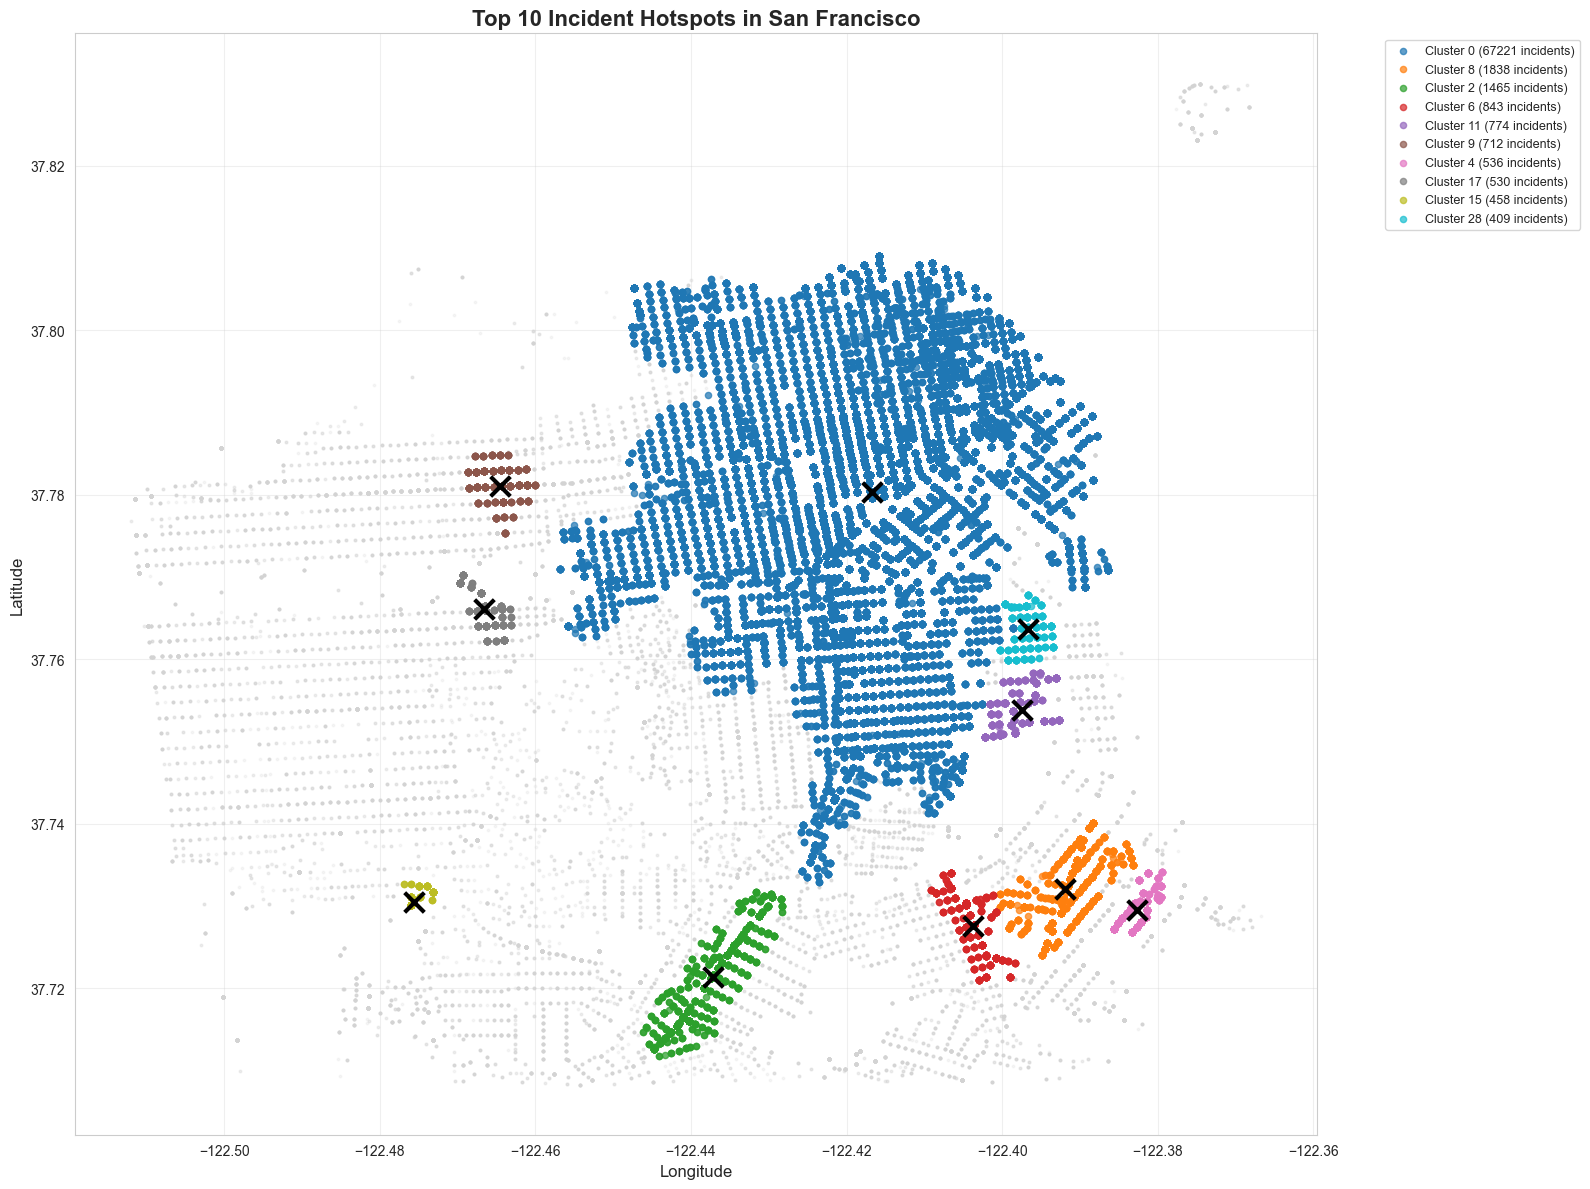

In [27]:
# Identify top clusters by size
if n_clusters > 0:
    cluster_info = df_sample[df_sample['Cluster'] != -1].groupby('Cluster').agg({
        'Latitude': ['mean', 'count'],
        'Longitude': 'mean',
        'Neighborhood': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    }).round(6)
    
    cluster_info.columns = ['Center_Lat', 'Size', 'Center_Lon', 'Neighborhood']
    cluster_info = cluster_info.sort_values('Size', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 20 INCIDENT HOTSPOTS (Largest Clusters)")
    print("="*80)
    print(cluster_info.head(20).to_string())
    
    # Visualize top 10 clusters
    top_10_clusters = cluster_info.head(10).index.tolist()
    
    plt.figure(figsize=(16, 12))
    
    # Plot all points in light gray as background
    plt.scatter(
        df_sample['Longitude'],
        df_sample['Latitude'],
        c='lightgray',
        alpha=0.2,
        s=3
    )
    
    # Highlight top 10 clusters
    for i, cluster_id in enumerate(top_10_clusters):
        cluster_data = df_sample[df_sample['Cluster'] == cluster_id]
        plt.scatter(
            cluster_data['Longitude'],
            cluster_data['Latitude'],
            label=f"Cluster {cluster_id} ({len(cluster_data)} incidents)",
            s=20,
            alpha=0.7
        )
        
        # Add cluster center marker
        center_lat = cluster_info.loc[cluster_id, 'Center_Lat']
        center_lon = cluster_info.loc[cluster_id, 'Center_Lon']
        plt.scatter(center_lon, center_lat, marker='x', s=200, c='black', linewidths=3)
    
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Top 10 Incident Hotspots in San Francisco', fontsize=16, weight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_dir / '08_top_10_hotspots.png', dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("No clusters found to analyze.")


## 9. Summary and Key Findings


In [28]:
print("="*80)
print("SPATIAL ANALYSIS SUMMARY - SAN FRANCISCO INCIDENTS")
print("="*80)
print(f"\n📊 Dataset Information:")
print(f"   • Total incidents analyzed: {len(df_sample):,}")
print(f"   • Date range: {df_sample.index.min().date()} to {df_sample.index.max().date()}")

print(f"\n🎯 DBSCAN Parameters:")
print(f"   • Epsilon (eps): {eps} (~1.1 km radius)")
print(f"   • Minimum samples: {min_samples}")

print(f"\n🗺️ Clustering Results:")
print(f"   • Number of clusters identified: {n_clusters:,}")
print(f"   • Incidents in clusters: {n_clustered:,} ({100*n_clustered/len(clusters):.1f}%)")
print(f"   • Noise/outlier points: {n_noise:,} ({100*n_noise/len(clusters):.1f}%)")

if n_clusters > 0:
    print(f"\n📈 Cluster Statistics:")
    print(f"   • Average cluster size: {cluster_sizes.mean():.1f} incidents")
    print(f"   • Median cluster size: {cluster_sizes.median():.0f} incidents")
    print(f"   • Largest cluster: {cluster_sizes.max():,} incidents")
    print(f"   • Smallest cluster: {cluster_sizes.min():,} incidents")
    
    print(f"\n🔥 Top 5 Hotspots:")
    for i, (cluster_id, row) in enumerate(cluster_info.head(5).iterrows(), 1):
        print(f"   {i}. Cluster {cluster_id}: {row['Size']:,} incidents - {row['Neighborhood']}")

print(f"\n💡 Key Insights:")
print("   • DBSCAN successfully identified spatial crime hotspots")
print("   • Hotspots represent areas requiring enhanced public safety resources")
print("   • Cluster analysis reveals geographic concentration of incident types")
print("   • Results can inform strategic deployment of law enforcement")

print("\n" + "="*80)


SPATIAL ANALYSIS SUMMARY - SAN FRANCISCO INCIDENTS

📊 Dataset Information:
   • Total incidents analyzed: 100,000
   • Date range: 2018-01-01 to 2025-11-16

🎯 DBSCAN Parameters:
   • Epsilon (eps): 0.002 (~1.1 km radius)
   • Minimum samples: 100

🗺️ Clustering Results:
   • Number of clusters identified: 60
   • Incidents in clusters: 84,052 (84.1%)
   • Noise/outlier points: 15,948 (15.9%)

📈 Cluster Statistics:
   • Average cluster size: 1400.9 incidents
   • Median cluster size: 198 incidents
   • Largest cluster: 67,221 incidents
   • Smallest cluster: 35 incidents

🔥 Top 5 Hotspots:
   1. Cluster 0: 67,221 incidents - Mission
   2. Cluster 8: 1,838 incidents - Bayview Hunters Point
   3. Cluster 2: 1,465 incidents - Excelsior
   4. Cluster 6: 843 incidents - Portola
   5. Cluster 11: 774 incidents - Potrero Hill

💡 Key Insights:
   • DBSCAN successfully identified spatial crime hotspots
   • Hotspots represent areas requiring enhanced public safety resources
   • Cluster analysis